<a href="https://colab.research.google.com/github/Debajyoti2004/coursera-test/blob/main/siamese_network_face_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras import backend as K

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
def create_pairs(x,digit_indices):
  pairs=[]
  labels=[]
  n=min(len(digit_indices[i]) for i in range(10))-1
  for d in range(10):
    for i in range(n):
      idx1=digit_indices[d][i]
      idx2=digit_indices[d][i+1]
      pairs+=[(x[idx1],x[idx2])]
      inc=random.randrange(1,10)
      dn=(d+inc)%10
      idx1=digit_indices[d][i]
      idx2=digit_indices[dn][i]
      pairs+=[(x[idx1],x[idx2])]
      labels+=[1,0]
  return np.array(pairs),np.array(labels)


In [ ]:
def create_pairs_on_set(image,labels):
  digit_indices=[np.where(labels==i)[0] for i in range(10)]
  pairs,labels=create_pairs(image,digit_indices)
  labels=labels.astype('float32')
  return pairs,labels

In [ ]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [ ]:
print(f"training pairs: {(tr_pairs.shape)}")
print(f"testing pairs: {(ts_pairs.shape)}")
print(f"training labels: {tr_y.shape}")
print(f"testing labels: {ts_y.shape}")

training pairs: (119980, 2, 28, 28)
testing pairs: (19980, 2, 28, 28)
training labels: (119980,)
testing labels: (19980,)


In [ ]:
def show_image(image, title=None, cmap=None, xlabel=None, ylabel=None):
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.grid(False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

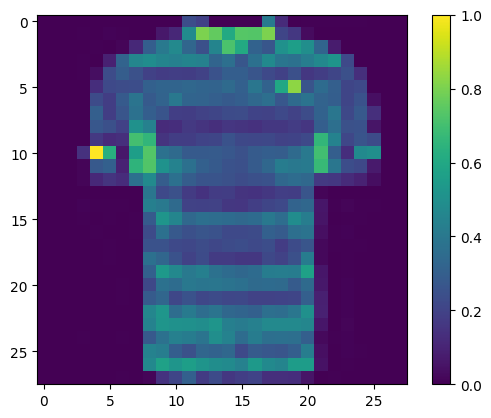

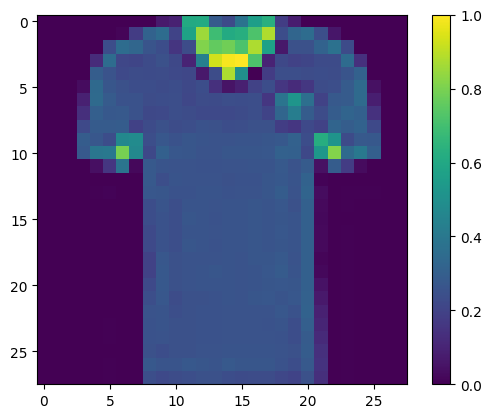

1.0


In [ ]:
# array index
this_pair = 4

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

In [ ]:
class base_network(Model):
  def __init__(self):
    super(base_network,self).__init__()
    self.flatten=Flatten(name="flatten")
    self.dense1=Dense(128,activation='relu',name="dense1")
    self.dropout1=Dropout(0.1,name="dropout1")
    self.dense2=Dense(128,activation='relu',name="dense2")
    self.dropout2=Dropout(0.1,name="dropout2")
    self.dense3=Dense(128,activation='relu',name="dense3")

  def call(self,input):
    x=self.flatten(input)
    x=self.dense1(x)
    x=self.dropout1(x)
    x=self.dense2(x)
    x=self.dropout2(x)
    x=self.dense3(x)
    return x

In [ ]:

input_size=(28,28)
input=Input(shape=input_size)
base_model=base_network()
y=base_model(input)

base_model.summary()


Model: "base_network_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense1 (Dense)              multiple                  100480    
                                                                 
 dropout1 (Dropout)          multiple                  0         
                                                                 
 dense2 (Dense)              multiple                  16512     
                                                                 
 dropout2 (Dropout)          multiple                  0         
                                                                 
 dense3 (Dense)              multiple                  16512     
                                                                 
Total params: 133504 (521.50 KB)
Trainable params: 

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
class siamese_network(Model):
  def __init__(self):
    super(siamese_network,self).__init__()
    self.base_model=base_network()
    self.lambda_=Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)

  def call(self,inputs):
    input1,input2=inputs
    X1=self.base_model(input1) #left input
    X2=self.base_model(input2) #right_input
    X=self.lambda_([X1,X2])
    return X


In [ ]:
input_size_left=(28,28)
input_size_right=(28,28)
input_left=Input(shape=input_size_left)
input_right=Input(shape=input_size_right)
siamese_model=siamese_network()
output=siamese_model([input_left,input_right])
siamese_model.summary()

Model: "siamese_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_network_11 (base_netw  multiple                  133504    
 ork)                                                            
                                                                 
 lambda_2 (Lambda)           multiple                  0         
                                                                 
Total params: 133504 (521.50 KB)
Trainable params: 133504 (521.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class Contrastive_loss(tf.keras.losses.Loss):
  def __init__(self,margin=1):
    super(Contrastive_loss,self).__init__()
    self.margin=margin

  def call(self,y_true,y_pred):
    square_pred=K.square(y_pred)
    margin_square=K.square(K.maximum(self.margin-y_pred,0))
    return (y_true*square_pred+(1-y_true)*margin_square)


In [ ]:
rms=RMSprop()
contrastive_loss=Contrastive_loss(margin=1)
siamese_model.compile(loss=contrastive_loss,optimizer=rms)
model_history=siamese_model.fit([tr_pairs[:,0],tr_pairs[:,1]],tr_y,batch_size=128,epochs=20,validation_data=([ts_pairs[:,0],ts_pairs[:,1]],ts_y))

Epoch 1/20
938/938 [==============================] - 13s 12ms/step - loss: 0.1137 - val_loss: 0.0857
Epoch 2/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0812 - val_loss: 0.0803
Epoch 3/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0730 - val_loss: 0.0778
Epoch 4/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0679 - val_loss: 0.0702
Epoch 5/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0651 - val_loss: 0.0713
Epoch 6/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0630 - val_loss: 0.0705
Epoch 7/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0611 - val_loss: 0.0677
Epoch 8/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0596 - val_loss: 0.0677
Epoch 9/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0584 - val_loss: 0.0658
Epoch 10/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0574 -

In [ ]:
def compute_accuracy(y_true, y_pred):

    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
loss =siamese_model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = siamese_model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = siamese_model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 2s 4ms/step
Loss = 0.06660337001085281, Train Accuracy = 0.933247207867978 Test Accuracy = 0.9075575575575575


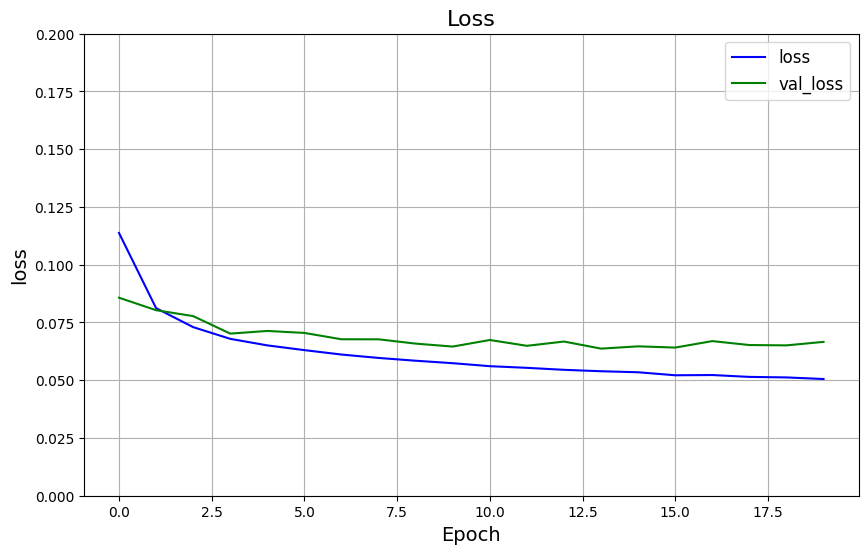

In [ ]:


def plot_metrics(metric_name, title, ylim=5):
    plt.figure(figsize=(10, 6))

    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)

    plt.grid(True)

    plt.ylim(0, ylim)

    plt.plot(model_history.history[metric_name], color='blue', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], color='green', label='val_' + metric_name)

    plt.legend(loc='upper right', fontsize=12)
    plt.show()


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)


In [ ]:

def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts



def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



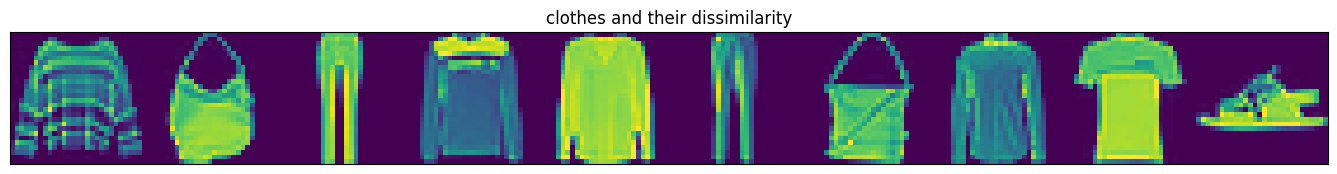

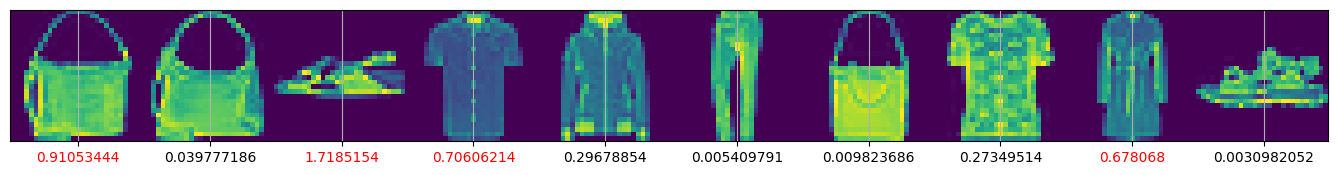

In [ ]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)